In [21]:
# 警告(worning)の非表示化
import warnings
warnings.filterwarnings('ignore')

# 3章 顧客の全体像を把握する１０本ノック

ここでは、スポーツジムの会員データを使って顧客の行動を分析していきます。  
これまでと同様にまずはデータを理解し、加工した後、  
顧客の行動データを分析していきましょう。  
ここでは、機械学習に向けての初期分析を行います。

### ノック21：データを読み込んで把握しよう

In [1]:
import pandas as pd
uselog = pd.read_csv("use_log.csv")
print(len(uselog))
uselog.head()

197428


,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [2]:
customer = pd.read_csv("customer_master.csv")
print(len(customer))
customer.head()

4192


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0


In [3]:
class_master = pd.read_csv("class_master.csv")
print(len(class_master))
class_master.head()

3


,class,class_name,price
0,C01,オールタイム,10500
1,C02,デイタイム,7500
2,C03,ナイト,6000


In [4]:
campaign_master = pd.read_csv("campaign_master.csv")
print(len(campaign_master))
campaign_master.head()

3


,campaign_id,campaign_name
0,CA1,通常
1,CA2,入会費半額
2,CA3,入会費無料


### ノック22：顧客データを整形しよう

In [6]:
customer_join = pd.merge(customer, class_master, on="class", how="left")
customer_join = pd.merge(customer_join, campaign_master, on="campaign_id", how="left")
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,ナイト,6000,通常


In [7]:
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

### ノック23：顧客データの基礎集計をしよう

In [8]:
customer_join.groupby("class_name").count()["customer_id"]

class_name
オールタイム    2045
デイタイム     1019
ナイト       1128
Name: customer_id, dtype: int64

In [9]:
customer_join.groupby("campaign_name").count()["customer_id"]

campaign_name
入会費半額     650
入会費無料     492
通常       3050
Name: customer_id, dtype: int64

In [10]:
customer_join.groupby("gender").count()["customer_id"]

gender
F    1983
M    2209
Name: customer_id, dtype: int64

In [11]:
customer_join.groupby("is_deleted").count()["customer_id"]

is_deleted
0    2842
1    1350
Name: customer_id, dtype: int64

In [12]:
customer_join["start_date"] = pd.to_datetime(customer_join["start_date"])
customer_start = customer_join.loc[customer_join["start_date"] > pd.to_datetime("20180401")]
print(len(customer_start))

1361


### ノック24：最新顧客データの基礎集計をしよう

In [13]:
customer_join["end_date"] = pd.to_datetime(customer_join["end_date"])
customer_newer = customer_join.loc[(customer_join["end_date"] >= pd.to_datetime("20190331")) | (customer_join["end_date"].isna())]
print(len(customer_newer))
customer_newer["end_date"].unique()

2953


array([                          'NaT', '2019-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [14]:
customer_newer.groupby("class_name").count()["customer_id"]

class_name
オールタイム    1444
デイタイム      696
ナイト        813
Name: customer_id, dtype: int64

In [15]:
customer_newer.groupby("campaign_name").count()["customer_id"]

campaign_name
入会費半額     311
入会費無料     242
通常       2400
Name: customer_id, dtype: int64

In [16]:
customer_newer.groupby("gender").count()["customer_id"]

gender
F    1400
M    1553
Name: customer_id, dtype: int64

### ノック25：利用履歴データを集計しよう

In [23]:
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["年月"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["年月","customer_id"],as_index=False).count()
uselog_months.rename(columns={"log_id":"count"}, inplace=True)
del uselog_months["usedate"]
uselog_months.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [24]:
uselog_customer = uselog_months.groupby("customer_id").agg(["mean", "median", "max", "min" ])["count"]
uselog_customer = uselog_customer.reset_index(drop=False)
uselog_customer.head()

,customer_id,mean,median,max,min
0,AS002855,4.500000,5.0,7,2
1,AS008805,4.000000,4.0,8,1
2,AS009013,2.000000,2.0,2,2
3,AS009373,5.083333,5.0,7,3
4,AS015233,7.545455,7.0,11,4


### ノック26：利用履歴データから定期利用フラグを作成しよう

In [25]:
uselog["weekday"] = uselog["usedate"].dt.weekday
uselog_weekday = uselog.groupby(["customer_id", "年月", "weekday"], as_index=False).count()[["customer_id", "年月", "weekday", "log_id"]]
uselog_weekday.rename(columns={"log_id": "count"}, inplace=True)
uselog_weekday.head()

,customer_id,年月,weekday,count
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1


In [26]:
uselog_weekday = uselog_weekday.groupby("customer_id",as_index=False).max()[["customer_id", "count"]]
uselog_weekday["routine_flg"] = 0
uselog_weekday["routine_flg"] = uselog_weekday["routine_flg"].where(uselog_weekday["count"]<4, 1)
uselog_weekday.head()

,customer_id,count,routine_flg
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


### ノック27：顧客データと利用履歴データを結合しよう

In [27]:
customer_join = pd.merge(customer_join, uselog_customer, on="customer_id", how="left")
customer_join = pd.merge(customer_join, uselog_weekday[["customer_id", "routine_flg"]], on="customer_id", how="left")
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1


In [28]:
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
mean                0
median              0
max                 0
min                 0
routine_flg         0
dtype: int64

### ノック28：会員期間を計算しよう

In [29]:
from dateutil.relativedelta import relativedelta
customer_join["calc_date"] = customer_join["end_date"]
customer_join["calc_date"] = customer_join["calc_date"].fillna(pd.to_datetime("20190430"))
customer_join["membership_period"] = 0
for i in range(len(customer_join)):
    delta = relativedelta(customer_join["calc_date"].iloc[i], customer_join["start_date"].iloc[i])
    customer_join["membership_period"].iloc[i] = delta.years*12 + delta.months
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1,2019-04-30,47


### ノック29：顧客行動の各種統計量を把握しよう

In [30]:
customer_join[["mean", "median", "max", "min"]].describe()

,mean,median,max,min
count,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269
std,1.777533,1.874874,2.168959,1.951565
min,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000
50%,5.000000,5.000000,8.000000,3.000000
75%,6.416667,6.500000,9.000000,4.000000
max,12.000000,12.000000,14.000000,12.000000


In [31]:
customer_join.groupby("routine_flg").count()["customer_id"]

routine_flg
0     779
1    3413
Name: customer_id, dtype: int64

(array([857., 774., 395., 368., 311., 331., 323., 237., 288., 308.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <a list of 10 Patch objects>)

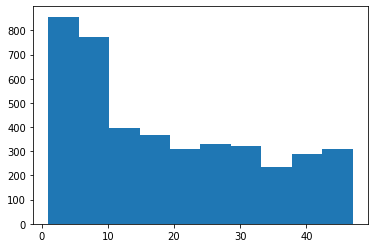

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(customer_join["membership_period"])

### ノック30：退会ユーザーと継続ユーザーの違いを把握しよう

In [33]:
customer_end = customer_join.loc[customer_join["is_deleted"]==1]
customer_end.describe()

,is_deleted,price,mean,median,max,min,routine_flg,membership_period
count,1350.0,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,1.0,8595.555556,3.865474,3.621852,6.461481,1.821481,0.456296,8.026667
std,0.0,1949.163652,1.246385,1.270847,2.584021,0.976361,0.498271,5.033692
min,1.0,6000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,1.0,6000.000000,3.000000,3.000000,4.000000,1.000000,0.000000,4.000000
50%,1.0,7500.000000,4.000000,4.000000,7.000000,2.000000,0.000000,7.000000
75%,1.0,10500.000000,4.666667,4.500000,8.000000,2.000000,1.000000,11.000000
max,1.0,10500.000000,9.000000,9.000000,13.000000,8.000000,1.000000,23.000000


In [34]:
customer_end = customer_join.loc[customer_join["is_deleted"]==0]
customer_end.describe()

,is_deleted,price,mean,median,max,min,routine_flg,membership_period
count,2842.0,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000
mean,0.0,8542.927516,6.030288,6.024279,8.471147,3.620690,0.984166,23.970443
std,0.0,1977.189779,1.553587,1.599765,1.571048,2.030488,0.124855,13.746761
min,0.0,6000.000000,3.166667,3.000000,5.000000,1.000000,0.000000,1.000000
25%,0.0,6000.000000,4.833333,5.000000,7.000000,2.000000,1.000000,12.000000
50%,0.0,7500.000000,5.583333,5.500000,8.000000,3.000000,1.000000,24.000000
75%,0.0,10500.000000,7.178030,7.000000,10.000000,5.000000,1.000000,35.000000
max,0.0,10500.000000,12.000000,12.000000,14.000000,12.000000,1.000000,47.000000


In [35]:
customer_join.to_csv("customer_join.csv", index=False)